# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np

from glob import glob
from PIL import Image
import cv2

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model, Sequential
from keras.applications import (
    ResNet50,
    InceptionV3,
    DenseNet121,
    VGG16,
    Xception)

import warnings
warnings.filterwarnings('ignore')


from utils import *

# Import Data

In [2]:
# Set the base directory to location #change
project_path = 'C:\\Users\\Afonso Cadete\\Documents\\Projects Data\\Deep Learning' #Afonso
# project_path = 'C:\\Users\\Afonso Cadete\\Documents\\Projects Data\\Deep Learning' #Daniel
# project_path = 'C:\\Users\\Afonso Cadete\\Documents\\Projects Data\\Deep Learning' #Marcelo
# project_path = 'C:\\Users\\Martin\\OneDrive - NOVAIMS\\Documents\\Universidade\\3º Ano\\Deep Learning\\Project' #Martim

# Merge images from both folders train and test into one dictionary
images_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(project_path, '*', '*.jpg'))}

# Read the metadata CSV file from directory
metadata = pd.read_csv(os.path.join(project_path, 'HAM10000_metadata.csv'))

# Create new columns for better readability #change
metadata['path'] = metadata['image_id'].map(images_path_dict.get)

# Convert image paths to NumPy arrays with RGB channels
metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image.open(x))) # RGB + faster than cv2.imread

# Create train and test dataframes
train_data = metadata[metadata['path'].str.contains('train')]
test_data = metadata[metadata['path'].str.contains('test')]

In [3]:
# # Delete unnecessary columns
# train_data.drop(columns=['lesion_id', 'image_id', 'path'], inplace=True)
# test_data.drop(columns=['lesion_id', 'image_id', 'path'], inplace=True)

# EDA

## Train percentage of Data

In [4]:
train_percentage(metadata, train_data)

Train represents 75.0%


## Missing Values

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7511 entries, 0 to 10014
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     7511 non-null   object 
 1   image_id      7511 non-null   object 
 2   dx            7511 non-null   object 
 3   dx_type       7511 non-null   object 
 4   age           7467 non-null   float64
 5   sex           7511 non-null   object 
 6   localization  7511 non-null   object 
 7   path          7511 non-null   object 
 8   image         7511 non-null   object 
dtypes: float64(1), object(8)
memory usage: 586.8+ KB


In [6]:
missing_values_percentage(train_data, 'age')

Percentage of "age" missing values: 0.59%


## Variable Distributions

### Numerical features

In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,7467.0,51.7122,16.944405,0.0,40.0,50.0,65.0,85.0


#### `age`

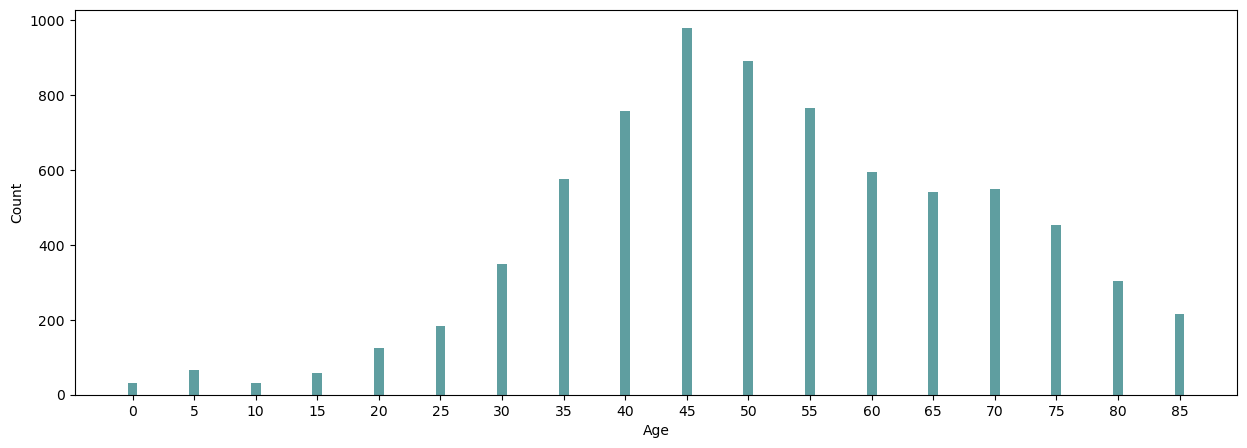

In [8]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'age', 'Age')

### Categorical features

In [9]:
train_data.iloc[:,:-1].describe(exclude=['number']).T

,count,unique,top,freq
lesion_id,7511,5998,HAM_0005263,6
image_id,7511,7511,ISIC_0027419,1
dx,7511,7,nv,5029
dx_type,7511,4,histo,4014
sex,7511,3,male,4052
localization,7511,15,back,1634
path,7511,7511,C:\Users\Afonso Cadete\Documents\Projects Data...,1


#### `dx` --- target

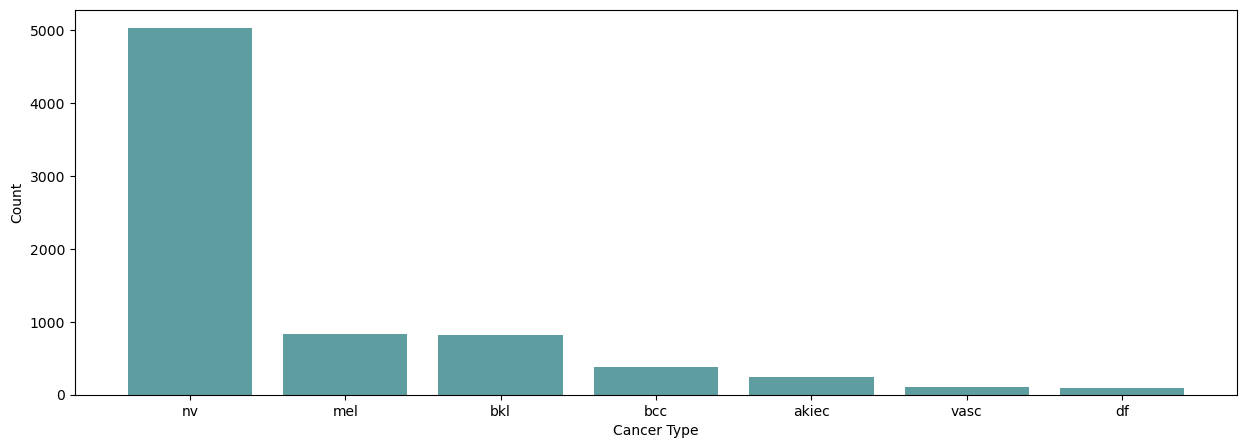

In [10]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'dx', 'Cancer Type')

#### `dx_type`

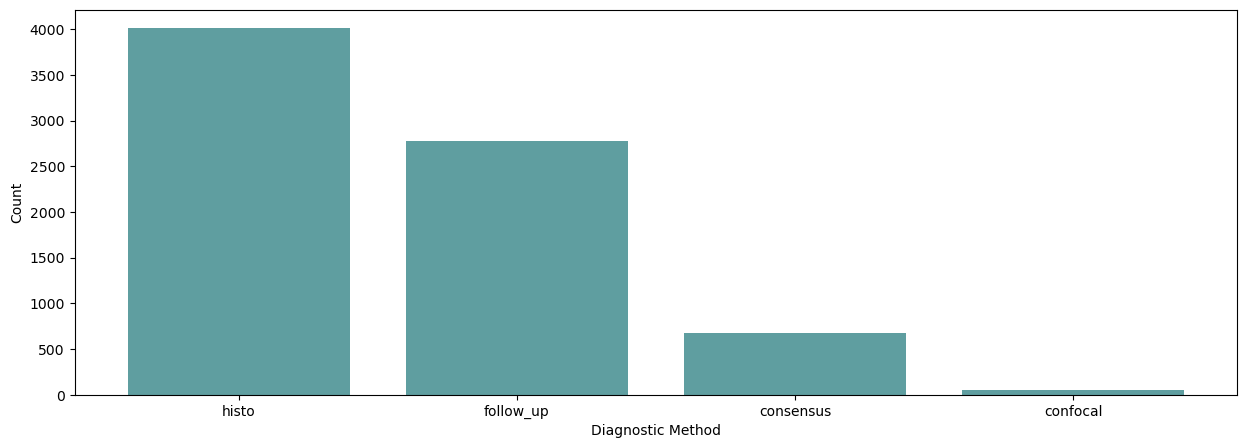

In [11]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'dx_type', 'Diagnostic Method')

#### `sex`

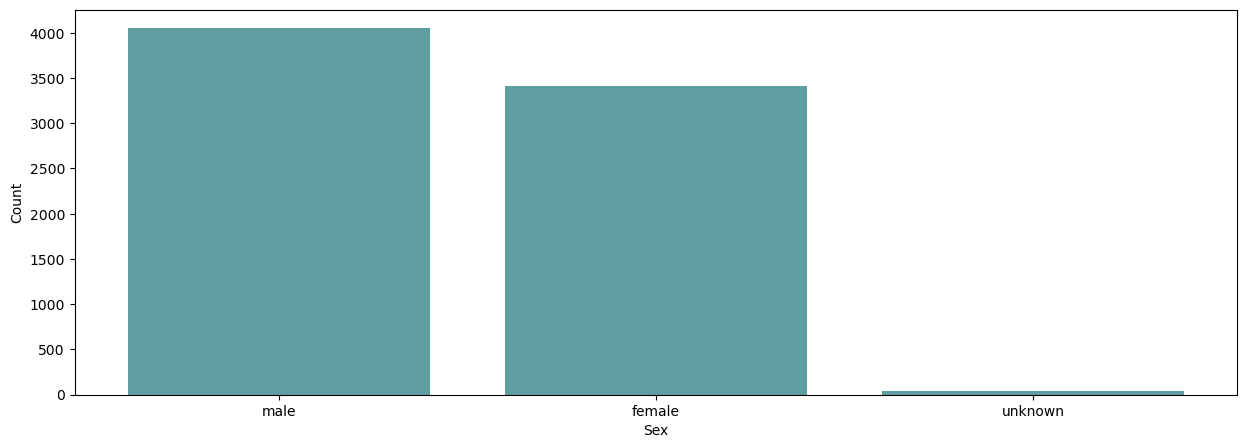

In [12]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'sex', 'Sex')

#### `localization`

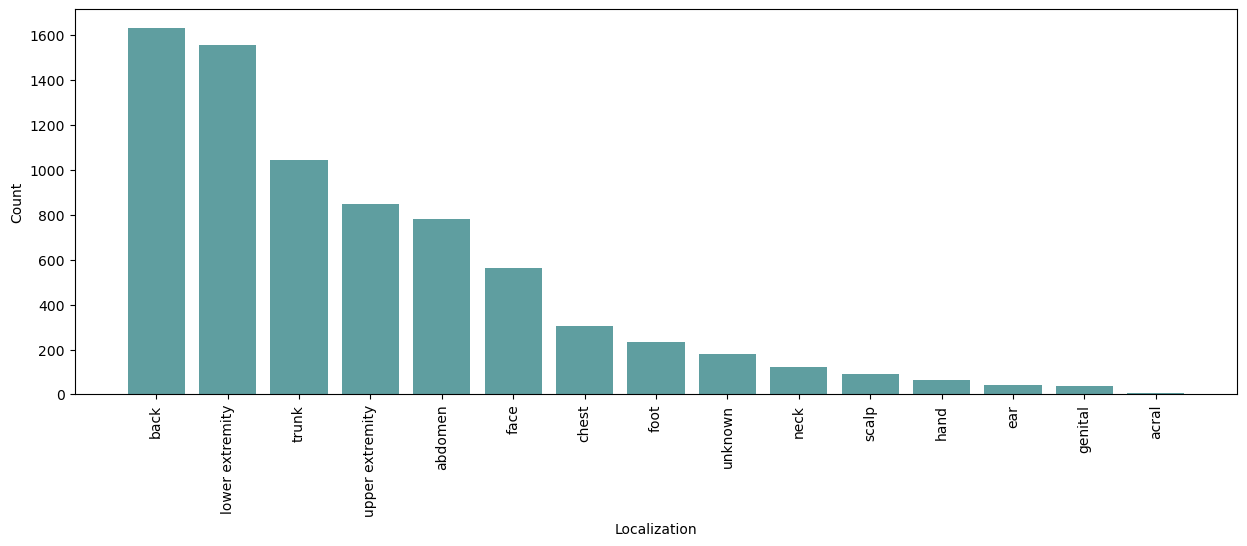

In [13]:
fig, ax = plt.subplots()
plt.xticks(rotation=90)
plot_bar_chart(ax, train_data, 'localization', 'Localization')

## Variable's `image` Structure

In [14]:
train_data['image'].map(lambda x: x.shape).value_counts() # height, width, channels

(450, 600, 3)    7511
Name: image, dtype: int64

## Duplicates

In [15]:
train_data['lesion_id'].duplicated().sum()

1513

In [16]:
train_data.iloc[:,:7].drop('image_id', axis=1).duplicated().sum()

1512

In [17]:
train_data[train_data['lesion_id'] == 'HAM_0001726'] # cancer spread (?)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image
1248,HAM_0001726,ISIC_0024367,mel,histo,35.0,female,back,C:\Users\Afonso Cadete\Documents\Projects Data...,"[[[51, 40, 38], [56, 40, 41], [58, 42, 45], [6..."
2008,HAM_0001726,ISIC_0024700,mel,histo,35.0,female,trunk,C:\Users\Afonso Cadete\Documents\Projects Data...,"[[[217, 138, 141], [219, 140, 145], [217, 137,..."


In [18]:
# train_data.drop_duplicates(subset='lesion_id', keep='first', inplace=True)

## Data Preprocessing

In [19]:
# Create a copy of the dataset for the sake of safety
train = train_data.copy()
# train = train_data.sample(frac=0.5, random_state=21) # if you want to sample the dataset

### Data Preparation

In [20]:
# Create a list with all values of each image
X_train = np.asarray(train['image'].tolist())
X_train

array([[[[188, 147, 191],
         [186, 148, 189],
         [187, 150, 191],
         ...,
         [196, 155, 171],
         [197, 156, 170],
         [197, 157, 168]],

        [[186, 149, 193],
         [187, 152, 194],
         [189, 153, 191],
         ...,
         [194, 156, 169],
         [195, 159, 169],
         [192, 159, 168]],

        [[185, 148, 192],
         [189, 152, 195],
         [190, 153, 196],
         ...,
         [196, 155, 169],
         [198, 157, 171],
         [194, 156, 169]],

        ...,

        [[157, 124, 155],
         [156, 121, 154],
         [159, 124, 154],
         ...,
         [177, 146, 161],
         [176, 144, 159],
         [175, 141, 155]],

        [[155, 122, 151],
         [156, 123, 154],
         [156, 123, 152],
         ...,
         [178, 147, 163],
         [175, 144, 159],
         [175, 142, 159]],

        [[154, 119, 151],
         [153, 120, 149],
         [154, 121, 152],
         ...,
         [176, 147, 167],
        

In [21]:
# Convert the target to a categorical feature and one-hot encode it
y_train = pd.Categorical(train['dx']).codes
y_train = to_categorical(y_train, num_classes=7)
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

### Image Enhancement

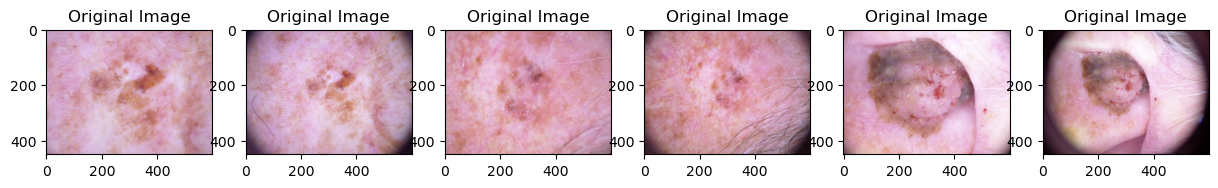

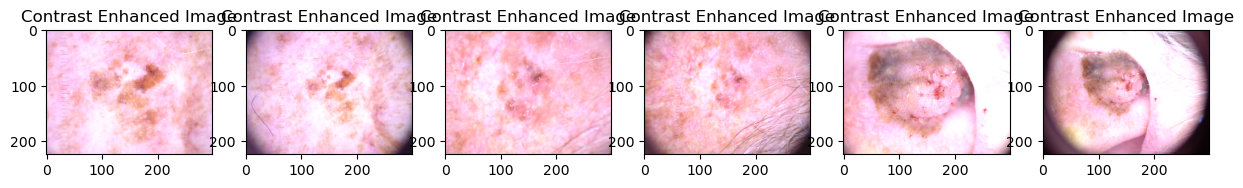

In [23]:
X_train_processed = apply_contrast_enhancement(X_train, alpha=1.2, beta=4, display=True)

### Data Partition

In [24]:
partial_X_train, X_val, partial_y_train, y_val = train_test_split(X_train_processed, y_train, 
                                                                   test_size=0.25, random_state=21,
                                                                   stratify=y_train, shuffle=True)

### Image Data Augmentation

In [28]:
IDG = ImageDataGenerator(rescale=1./255,
                        rotation_range=35,  # randomly rotate images in the range (degrees, 0 to 180)
                        zoom_range=0.12, # randomly zoom image
                        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
                        horizontal_flip=True,  # randomly flip images
                        vertical_flip=True # randomly flip images
                        )

In [29]:
IDG.fit(partial_X_train)

# Modelling

In [32]:
base_model = keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 299, 3),
    pooling=None,
    )

for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dense(728, activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(728, activation='relu'))
model.add(Dense(7, activation='softmax'))

early_stop = EarlyStopping(monitor='val_loss', patience=3)

58889256/58889256 [==============================] - 8s 0us/step


In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(IDG.flow(partial_X_train, partial_y_train, batch_size=128),
                    validation_data=(X_val, y_val), 
                    epochs=10, callbacks=[early_stop])

Epoch 1/10
45/45 [==============================] - 964s 21s/step - loss: 1.1488 - accuracy: 0.6664 - val_loss: 4.0222 - val_accuracy: 0.6283
Epoch 2/10
 3/45 [=>............................] - ETA: 12:33 - loss: 0.8905 - accuracy: 0.7057

KeyboardInterrupt: 

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
